In [ ]:
!pip install torchmetrics --quiet
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
import os
import csv
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torchmetrics import AUROC, F1Score

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your files in Google Drive
drive_path = '/content/drive/My Drive/Kaggle/'

# Load the data
train_x = pd.read_csv(drive_path + 'train_x.csv')
train_y = pd.read_csv(drive_path + 'train_y.csv')
val_x = pd.read_csv(drive_path + 'val_x.csv')
val_y = pd.read_csv(drive_path + 'val_y.csv')
test_x = pd.read_csv(drive_path + 'test_x.csv')


Mounted at /content/drive


In [ ]:
#Create joined datasets
train_data = pd.concat([train_x, train_y], axis=1)
val_data = pd.concat([val_x, val_y], axis=1)

In [ ]:
display(train_data.head())

,index,string,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,even up here.......BLACKS!,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,Blame men. There's always an excuse to blame ...,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,2,You have no business making any comments on th...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,3,"""Let's get the black folks and the white folks...",0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,4,I guess the issue is people not willing to put...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


# Exploratory Data Analysis

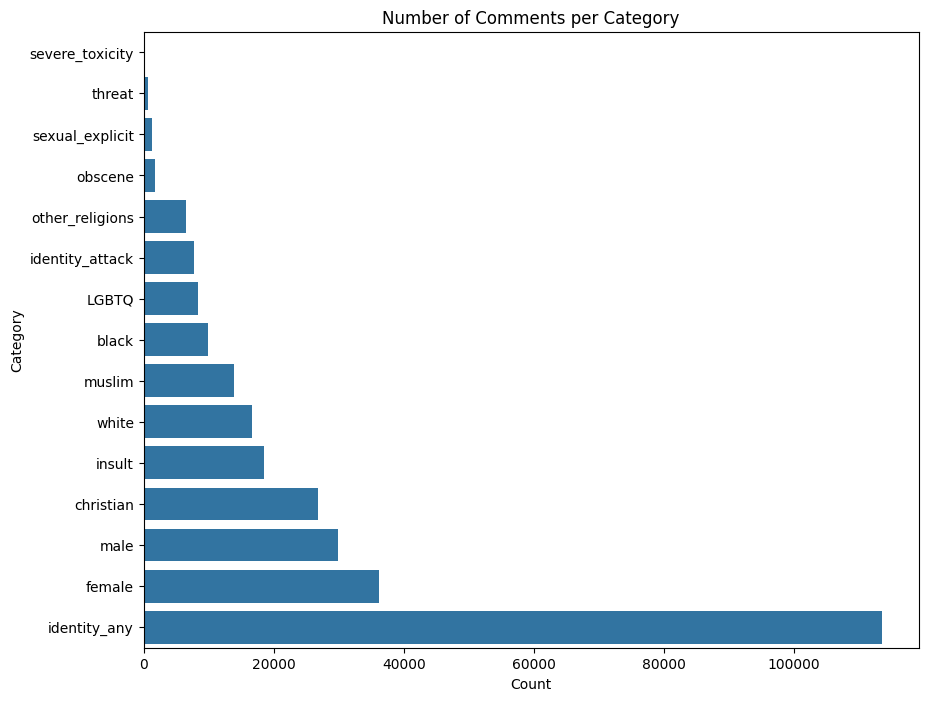

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd

# Load the dataset if not already loaded
# train_data = pd.read_csv('path_to_train_data.csv')

# 1. Bar chart showing the count of comments for each category
categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions',
              'black', 'white', 'identity_any', 'severe_toxicity', 'obscene',
              'threat', 'insult', 'identity_attack', 'sexual_explicit']

counts = train_data[categories].sum().sort_values()

plt.figure(figsize=(10, 8))
sns.barplot(x=counts.values, y=counts.index)
plt.title('Number of Comments per Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()









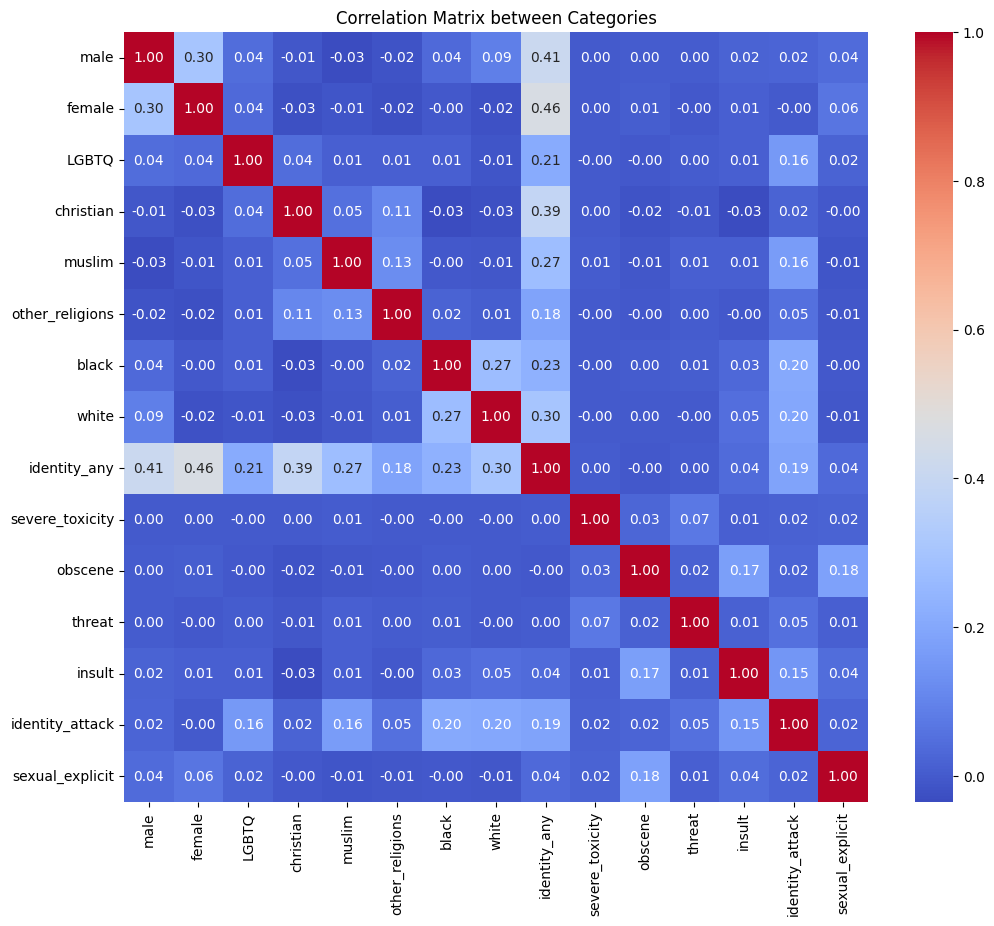

In [ ]:
# 2. Heatmap for the correlation matrix between categories
correlation_matrix = train_data[categories].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix between Categories')
plt.show()

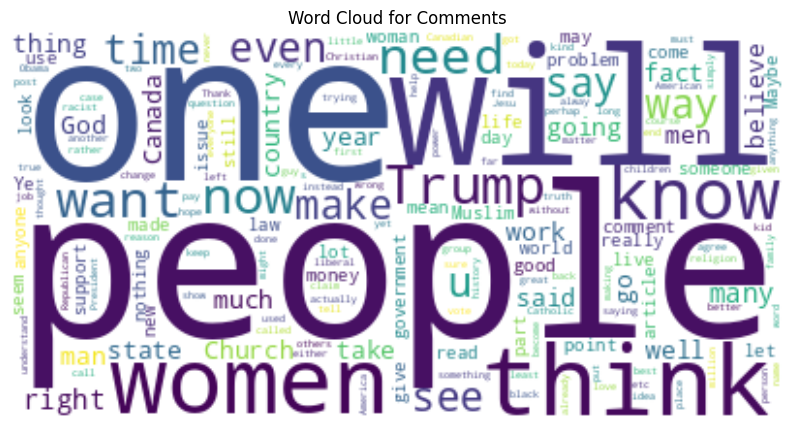

In [ ]:
# 3. Word cloud for the most frequent words in the comments
text = ' '.join(train_data['string'].astype(str).tolist())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Comments')
plt.show()

<Figure size 1400x800 with 0 Axes>

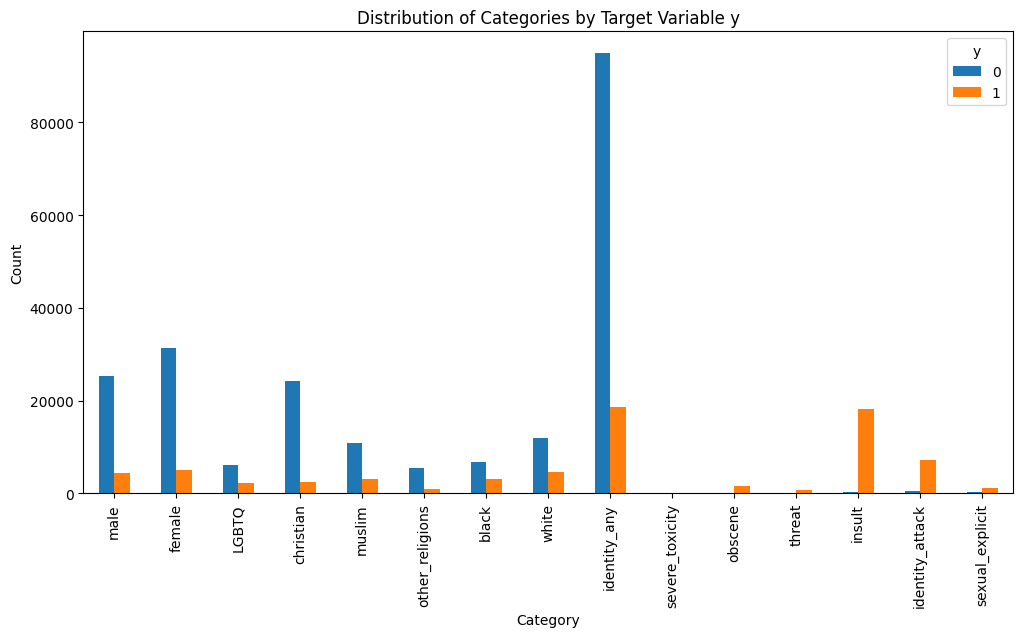

In [ ]:
# 4. Bar chart to compare the distribution of y across categories
y_counts = train_data.groupby('y')[categories].sum()

plt.figure(figsize=(14, 8))
y_counts.T.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Categories by Target Variable y')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

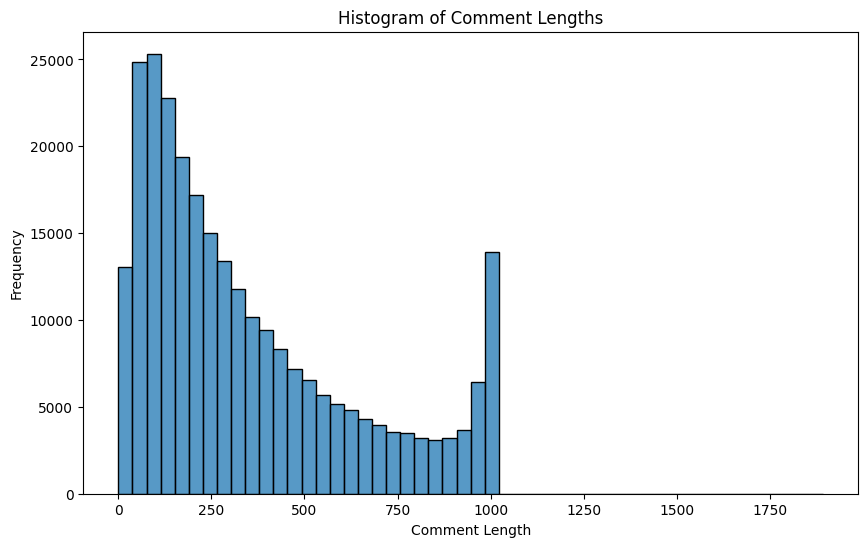

In [ ]:

# 5. Histogram of comment lengths
comment_lengths = train_data['string'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(comment_lengths, bins=50)
plt.title('Histogram of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

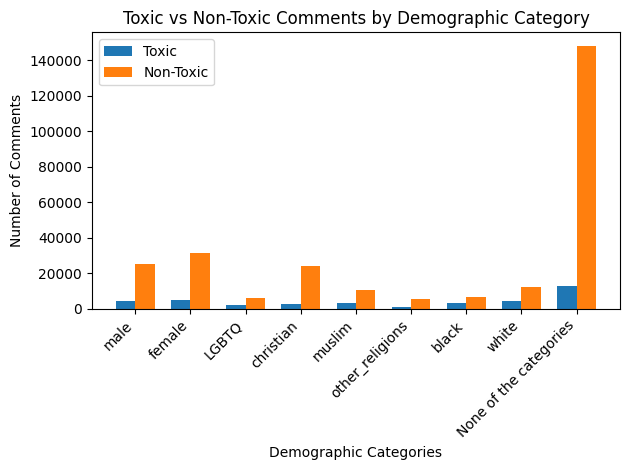

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data
df = pd.DataFrame(train_data)

# Categories of interest
categories = ["male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]

# Count toxic and non-toxic comments for each category
toxic_counts = []
nontoxic_counts = []
for category in categories:
    toxic_count = df[(df[category] == 1) & (df['y'] == 1)].shape[0]
    nontoxic_count = df[(df[category] == 1) & (df['y'] == 0)].shape[0]
    toxic_counts.append(toxic_count)
    nontoxic_counts.append(nontoxic_count)

# Add counts for comments that don't fit in any category
df['sum_categories'] = df[categories].sum(axis=1)
toxic_count_none = df[(df['sum_categories'] == 0) & (df['y'] == 1)].shape[0]
nontoxic_count_none = df[(df['sum_categories'] == 0) & (df['y'] == 0)].shape[0]
toxic_counts.append(toxic_count_none)
nontoxic_counts.append(nontoxic_count_none)
categories.append('None of the categories')  # Add a label for the 'None of the categories' data

# Plotting
bar_width = 0.35
index = np.arange(len(categories))  # Use np.arange instead of pd.np.arange
fig, ax = plt.subplots()
bar1 = ax.bar(index, toxic_counts, bar_width, label='Toxic')
bar2 = ax.bar(index + bar_width, nontoxic_counts, bar_width, label='Non-Toxic')

# Labeling
ax.set_xlabel('Demographic Categories')
ax.set_ylabel('Number of Comments')
ax.set_title('Toxic vs Non-Toxic Comments by Demographic Category')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Data preprocessing

## Tokenizing

In [ ]:
from transformers import DistilBertTokenizer

# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
class TokenizedCommentDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len: int, eval_mode: bool = False,):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.comments = dataframe.string
        self.max_len = max_len
        self.eval_mode = eval_mode
        self.demographic_columns = ["male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]
        if not self.eval_mode:
            self.y = self.data.y
            self.demographic_columns = ["male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, index):
        comment = str(self.comments.iloc[index])
        inputs = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len
        )

        # Preparing the dictionary to be returned
        output = {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'comment': comment,
            'tokens': self.tokenizer.convert_ids_to_tokens(inputs['input_ids']),
            'index': index,
            'y': torch.tensor(self.data.y.iloc[index], dtype=torch.int),

        }
        for column in self.demographic_columns:
          output[column] = torch.tensor(self.data[column].iloc[index], dtype=torch.int)

        if not self.eval_mode:
            output['y'] = torch.tensor(self.y.iloc[index], dtype=torch.int)
            for column in self.demographic_columns:
                output[column] = torch.tensor(self.data[column].iloc[index], dtype=torch.int)

        return output

In [ ]:
max_len = 512
train_dataset = TokenizedCommentDataset(train_data, tokenizer, max_len, eval_mode=False)
val_dataset = TokenizedCommentDataset(val_data, tokenizer, max_len, eval_mode=True)


In [ ]:
train_dataset[0]

{'ids': tensor([  101,  2130,  2039,  2182,  1012,  1012,  1012,  1012,  1012,  1012,
          1012, 10823,   999,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [ ]:
# Creating Dataloader
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 32
NUM_WORKERS = 0

# Create DataLoader for training data
training_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

# Create DataLoader for validation data
validation_loader = DataLoader(
    dataset=val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

def custom_collate_fn(batch):
    # Check and handle missing 'y' in the batch
    # Return the batch or a modified version of it
    return batch

## Neural Network

In [ ]:
from transformers import DistilBertModel
import torch

class DistilBERTClass(torch.nn.Module):

    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 1)
        self.tanh = torch.nn.Tanh()

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = self.tanh(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTClass()
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

## Loss function and optimizer

In [ ]:
import torch

def loss_fn(outputs, targets):
    loss_function = torch.nn.BCEWithLogitsLoss()
    return loss_function(outputs.view(-1), targets.view(-1))

LEARNING_RATE = 1e-05

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

def worst_group_accuracy(prediction, y):

    y.loc[prediction.index, 'pred'] = prediction['prediction']

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies_dict = {}

    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies_dict[(category, label)] = group_accuracy

    worst_group = min(accuracies_dict, key=accuracies_dict.get)
    wga = accuracies_dict[worst_group]

    return wga, worst_group, accuracies_dict

def analyze_model_performance(data_loader, model):
    model.eval()
    total_validation_loss, total_validation_accuracy, all_predictions = 0, 0, []
    all_true_labels = {key: [] for key in ['y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']}

    with torch.no_grad():
        for data in tqdm(data_loader, desc='Evaluating', leave=False):
            input_ids = data['ids'].to(device, dtype=torch.long)
            attention_mask = data['mask'].to(device, dtype=torch.long)
            true_values = data['y'].to(device, dtype=torch.float)

            model_predictions = model(input_ids, attention_mask).squeeze()
            loss = loss_fn(model_predictions, true_values)

            total_validation_loss += loss.item()
            total_validation_accuracy += accuracy_score(true_values.cpu().numpy(), model_predictions.cpu().numpy().round())
            all_predictions.extend(model_predictions.cpu().numpy())
            for key in all_true_labels.keys():
                all_true_labels[key].extend(data[key].cpu().numpy())

    average_validation_loss = total_validation_loss / len(data_loader)
    average_validation_accuracy = total_validation_accuracy / len(data_loader)

    least_accuracy, least_accurate_group, group_accuracy_details = worst_group_accuracy(pd.DataFrame({'prediction': all_predictions}), pd.DataFrame(all_true_labels))

    return average_validation_loss, average_validation_accuracy, least_accuracy, least_accurate_group, group_accuracy_details

def execute_training(num_epochs, training_data_loader, validation_data_loader):
    training_losses, validation_losses = [], []
    training_least_accuracies, validation_least_accuracies = [], []
    training_least_accurate_groups, validation_least_accurate_groups = [], []
    accuracies_per_group_during_training, accuracies_per_group_during_validation = [], []

    for epoch in range(num_epochs):
        model.train()
        cumulative_loss = 0
        epoch_predictions = []
        epoch_true_labels = {key: [] for key in ['y', 'male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']}

        for batch in tqdm(training_data_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            input_ids = batch['ids'].to(device, dtype=torch.long)
            attention_mask = batch['mask'].to(device, dtype=torch.long)
            true_values = batch['y'].to(device, dtype=torch.float)

            optimizer.zero_grad()
            predictions = model(input_ids, attention_mask).squeeze()
            loss = loss_fn(predictions, true_values)
            loss.backward()
            optimizer.step()

            cumulative_loss += loss.item()
            epoch_predictions.extend(predictions.cpu().detach().numpy())
            for key in epoch_true_labels.keys():
                epoch_true_labels[key].extend(batch[key].cpu().numpy())

        average_loss_during_training = cumulative_loss / len(training_data_loader)
        training_losses.append(average_loss_during_training)

        training_least_accuracy, training_least_accurate_group, training_group_accuracy_details = worst_group_accuracy(pd.DataFrame({'prediction': epoch_predictions}), pd.DataFrame(epoch_true_labels))
        training_least_accuracies.append(training_least_accuracy)
        training_least_accurate_groups.append(training_least_accurate_group)
        accuracies_per_group_during_training.append(training_group_accuracy_details)

        average_validation_loss, average_validation_accuracy, validation_least_accuracy, validation_least_accurate_group, validation_group_accuracy_details = analyze_model_performance(validation_data_loader, model)
        validation_losses.append(average_validation_loss)
        validation_least_accuracies.append(validation_least_accuracy)
        validation_least_accurate_groups.append(validation_least_accurate_group)
        accuracies_per_group_during_validation.append(validation_group_accuracy_details)

        print(f'Training Loss: {average_loss_during_training:.4f}, Training Least Group Accuracy: {training_least_accuracy:.4f}, Validation Loss: {average_validation_loss:.4f}, Validation Least Group Accuracy: {validation_least_accuracy:.4f}')

        sorted_training_group_accuracies = dict(sorted(training_group_accuracy_details.items(), key=lambda item: item[1]))
        print(f"Sorted Training Group Accuracies: {sorted_training_group_accuracies}")

        sorted_validation_group_accuracies = dict(sorted(validation_group_accuracy_details.items(), key=lambda item: item[1]))
        print(f"Sorted Validation Group Accuracies: {sorted_validation_group_accuracies}")

    epoch_range = range(1, len(training_losses) + 1)
    fig, (loss_axis, accuracy_axis) = plt.subplots(1, 2, figsize=(20, 6))

    loss_axis.plot(epoch_range, training_losses, label='Training Loss', color='blue')
    loss_axis.plot(epoch_range, validation_losses, label='Validation Loss', color='red')
    loss_axis.set_title('Training and Validation Loss Over Epochs')
    loss_axis.set_xlabel('Epochs')
    loss_axis.set_ylabel('Loss')
    loss_axis.legend()
    loss_axis.grid(True)

    for group in accuracies_per_group_during_training[0].keys():
        training_group_accuracy = [accuracy[group] for accuracy in accuracies_per_group_during_training]
        validation_group_accuracy = [accuracy[group] for accuracy in accuracies_per_group_during_validation]

        accuracy_axis.plot(epoch_range, training_group_accuracy, color='green', alpha=0.5)
        accuracy_axis.plot(epoch_range, validation_group_accuracy, color='orange', alpha=0.5)

    accuracy_axis.set_title('Training and Validation Accuracies for Each Group Over Epochs')
    accuracy_axis.set_xlabel('Epochs')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.legend(['Training Accuracies', 'Validation Accuracies'], loc='upper left')
    accuracy_axis.grid(True)

    plt.tight_layout()
    plt.show()

    return training_losses, training_least_accuracies, training_least_accurate_groups, accuracies_per_group_during_training, validation_losses, validation_least_accuracies, validation_least_accurate_groups, accuracies_per_group_during_validation


In [ ]:
total_training_data_points = len(train_dataset)
print(total_training_data_points)

269038


Epoch 1/1 - Training: 100%|██████████| 8408/8408 [3:22:21<00:00,  1.44s/it]


Training Loss: 0.1865, Training Least Group Accuracy: 0.7739, Validation Loss: 0.1733, Validation Least Group Accuracy: 0.7887
Sorted Training Group Accuracies: {('black', 1): 0.773949070331447, ('LGBTQ', 1): 0.7882422802850356, ('white', 1): 0.7948257276320517, ('muslim', 1): 0.8293679231761502, ('other_religions', 1): 0.8811124694376528, ('male', 1): 0.8941965783294197, ('female', 1): 0.9010043041606887, ('christian', 0): 0.9208955839867933, ('other_religions', 0): 0.9224172742996031, ('female', 0): 0.9245899808414306, ('male', 0): 0.9248039527145652, ('LGBTQ', 0): 0.9257150311950825, ('christian', 1): 0.9260976886827735, ('muslim', 0): 0.926447758385473, ('black', 0): 0.9270438601230213, ('white', 0): 0.9297891733375604}
Sorted Validation Group Accuracies: {('black', 1): 0.7887409200968523, ('white', 1): 0.7997907220090688, ('LGBTQ', 1): 0.8140013726835964, ('muslim', 1): 0.8327014218009479, ('other_religions', 1): 0.8864097363083164, ('male', 1): 0.9007345225603358, ('female', 1): 

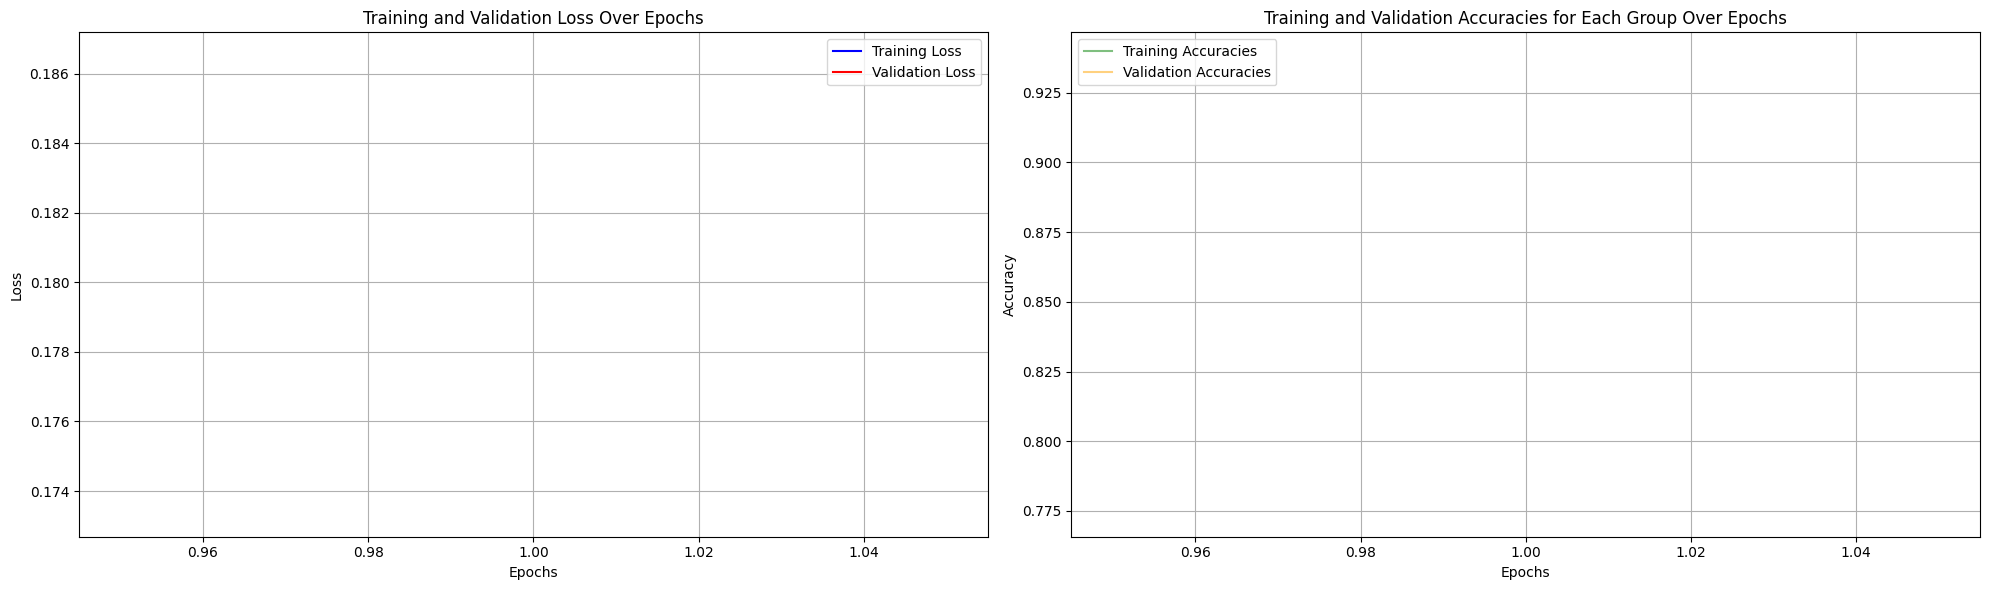

Epoch 1:
  Training Loss: 0.1865304209635089
  Training Accuracy: 0.226050929668553
  Validation Loss: 0.17334537746674294
  Validation Accuracy: 0.21125907990314774
  Group ('male', 0) Accuracy: 0.9248039527145652
  Group ('male', 1) Accuracy: 0.8941965783294197
  Group ('female', 0) Accuracy: 0.9245899808414306
  Group ('female', 1) Accuracy: 0.9010043041606887
  Group ('LGBTQ', 0) Accuracy: 0.9257150311950825
  Group ('LGBTQ', 1) Accuracy: 0.7882422802850356
  Group ('christian', 0) Accuracy: 0.9208955839867933
  Group ('christian', 1) Accuracy: 0.9260976886827735
  Group ('muslim', 0) Accuracy: 0.926447758385473
  Group ('muslim', 1) Accuracy: 0.8293679231761502
  Group ('other_religions', 0) Accuracy: 0.9224172742996031
  Group ('other_religions', 1) Accuracy: 0.8811124694376528
  Group ('black', 0) Accuracy: 0.9270438601230213
  Group ('black', 1) Accuracy: 0.773949070331447
  Group ('white', 0) Accuracy: 0.9297891733375604
  Group ('white', 1) Accuracy: 0.7948257276320517


In [ ]:
def format_epoch_results(epoch, training_loss, training_accuracy, validation_loss, validation_accuracy, group_accuracies):
    """
    Format and print the results for each epoch.
    """
    print(f"Epoch {epoch}:")
    print(f"  Training Loss: {training_loss}")
    print(f"  Training Accuracy: {training_accuracy}")
    print(f"  Validation Loss: {validation_loss}")
    print(f"  Validation Accuracy: {validation_accuracy}")

    # Assuming group_accuracies is a dictionary
    for group, accuracy in group_accuracies.items():
        print(f"  Group {group} Accuracy: {accuracy}")

# Usage example
EPOCHS = 1
(train_losses, train_least_accuracies, train_least_accurate_groups,
 accuracies_per_group_during_training, val_losses, val_least_accuracies,
 val_least_accurate_groups, accuracies_per_group_during_validation) = execute_training(EPOCHS, training_loader, validation_loader)

# Iterate through each epoch and call the formatting function
for epoch in range(EPOCHS):
    # Gather the data for the current epoch
    epoch_data = {
        'epoch': epoch + 1,  # epochs are usually 1-indexed in reporting
        'training_loss': train_losses[epoch],
        'training_accuracy': 1 - train_least_accuracies[epoch],  # Assuming accuracy is 1 - least_accuracy
        'validation_loss': val_losses[epoch],
        'validation_accuracy': 1 - val_least_accuracies[epoch],  # Assuming accuracy is 1 - least_accuracy
        'group_accuracies': accuracies_per_group_during_training[epoch]  # Assuming this is a dictionary
    }

    # Call the function with the gathered data
    format_epoch_results(**epoch_data)


In [ ]:
test_x.head()

,index,string
0,0,OH yes - Were those evil Christian Missionarie...
1,1,He's considered a good candidate for a cyber-s...
2,2,"Lela, you admit no records exist to support yo..."
3,3,I'll take the iffy libertarian over the guy wh...
4,4,Shouldn't your handle be Republic of Uranus?


In [ ]:
from transformers import DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.auto import tqdm

class TestDataset(Dataset):
    def __init__(self, ids, texts, tokenizer, max_token_len=64):
        self.ids = ids
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text_id = self.ids[index]
        text = self.texts[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'id': text_id,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Prepare IDs and texts
test_ids = test_x['index'].tolist()
test_texts = test_x['string'].tolist()

# Create the dataset and dataloader
test_dataset = TestDataset(test_ids, test_texts, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Assuming model is your trained DistilBERTClass model instance
# and it's already loaded with the trained weights and sent to the appropriate device
model.eval()  # Set the model to evaluation mode

test_ids_collected = []  # Initialize an empty list to collect IDs
test_predictions = []

for batch in tqdm(test_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    text_ids = batch['id']  # Retrieve IDs from the batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).squeeze()
        test_predictions.extend(preds.cpu().numpy())
        test_ids_collected.extend(text_ids.cpu().numpy())  # Collect IDs

# Create a DataFrame from the IDs and predictions
pred_df = pd.DataFrame({'ID': test_ids_collected, 'pred': test_predictions})

# Save the DataFrame to a CSV file
pred_df.to_csv('prediction.csv', index=False)

# Confirm the saving process
print("Predictions saved to prediction.csv.")


  0%|          | 0/262 [00:00<?, ?it/s]

Predictions saved to prediction.csv.


Once we are happy with our results, we want to make a prediction on the test set. Your submission `.csv` file should contain 2 columns:
- ID: with the id of each prediction (do not shuffle to not mix things up)
- pred: the prediction of the model (thresholded or not)

In [ ]:
from google.colab import files
files.download('prediction.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>